In [3]:
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as sps # to calcualte confidence intervals, etc
from adjustText import adjust_text # to adjust the text labels in the plots (pip install adjustText)

from statsmodels.stats.anova import AnovaRM # perform F test

In [4]:
# setting directories
base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/cifs/diedrichsen/data/FunctionalFusion'
atlas_dir = base_dir + '/Atlases'

In [20]:
# Functions
# prepare dataframe for plotting
def prep_df(dataframe, agg_kw = {}, groupby = "cond_name"):
    """
    prepare the region dataframe to do the scatter plot
    gets the mean across subjects (data point) and std of residuals
    Args:
        dataframe (pd.DataFrame) - dataframe with residuals info 
        agg_kw (dict) - dictionary determining info for dataframe aggregation

    Returns:
    g_df (pd.DataFrame) - dataframe ready for putting into the scatterplot function
    """
    # group by condition
    grouped = dataframe.groupby([groupby])
    g_df = grouped.agg(agg_kw)
    
    g_std = grouped.std(numeric_only=True)
    g_df["Y_CI"] = grouped.Y.apply(sps.sem) * 1.96
    g_df["X_CI"] = grouped.X.apply(sps.sem)*1.96
    g_df['err'] = g_std['res']
    
    return g_df


# plotting:
def make_plot(dataframe, hue = "cond_name", style = "cond_name", height = 4, aspect = 1):
    """
    make scatterplot
    uses FacetGrid 
    Args: 
    dataframe (pd.DataFrame) - output from prep_df
    hue (str)      - column name to be used to determine color
    style (str)    - column name to be used to determine shape of the marker
    label (str)    - column name to be used to determine the label of the data points
    height (int)   - int to determine the height of the plot
    aspect (float) - floating number to determine the aspect ratio of the plot
    """
    g = sns.FacetGrid(dataframe,  height=height, aspect=aspect)
    # do the scatter plot
    g.map_dataframe(sns.scatterplot, x="X", y="Y", 
                                    style = style, hue = hue, s = 50)
    g.add_legend()

    # fit the regression on top of the scatterplot
    g.map_dataframe(sns.regplot, x="X", y="Y", 
                        fit_reg=True, 
                        scatter_kws={"s": 0}, # size is set to 0 so that it doesn't cover the markers created in the scatterplot step 
                        line_kws={'label':"Linear Reg", "color": 'grey'})

    # put the errorbars in 
    g.map(plt.errorbar, x = df_preped['X'], 
                        y = df_preped['Y'], 
                        yerr = df_preped['err'],
                        elinewidth=1, 
                        fmt='none', # no marker will be used when plotting the error bars
                        color='grey', 
                        ecolor='0.9'
                )
    # set labels
    g.set_xlabels('Cortical Activation (a.u.)')
    g.set_ylabels('Cerebellar Activation (a.u.)')


In [15]:
# load the dataframe for the whole 
df_path = os.path.join(base_dir, "MDTB", "sc_df_whole_ses-s2.tsv")
df = pd.read_csv(df_path, sep="\t")

conditions_df = df[df['cond_name'].isin(['PredictViol','Prediction','PredictScram'])]

# prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(conditions_df, groupby = "cond_name", agg_kw=agg_kw)

print(df_preped)

                 cond_name         X         Y       res      Y_CI      X_CI  \
cond_name                                                                      
PredictScram  PredictScram -0.015178 -0.008319 -0.001231  0.005379  0.007603   
PredictViol    PredictViol -0.023939 -0.013001 -0.000862  0.006123  0.007784   
Prediction      Prediction -0.018731 -0.009618 -0.000430  0.005675  0.006494   

                   err  
cond_name               
PredictScram  0.015056  
PredictViol   0.014301  
Prediction    0.016415  


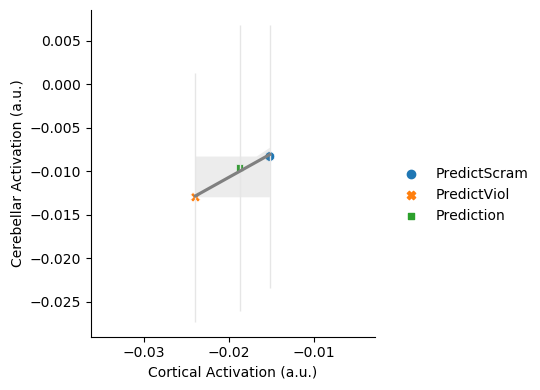

In [29]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [23]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=conditions_df, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  0.0552 2.0000 46.0000 0.9463

